# Assignment 2

### Om Khokhar (s3886577)
### Lakindu Bandara Dissanayake (s3847576)

## <div align="center"> Classify Images of Road Traffic Signs </div>

### In this module we will be predicting the shape of the traffic signs

## Dataset
The dataset is a modified version of the Belgium Traffic Sign Classification Benchmark.
The dataset consists of 28x28 gray-scale images.


#### Importing required packages

In [96]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

import zipfile

from PIL import Image
import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Reading the data

In [97]:
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Splitting validaton training data

In [98]:
val_signs = []

Now we iterate through the subfolders and read all the file names for the shapes of the signs and create a dataframe that can be used for training and testing 

In [99]:
image_list = []
for filepath in glob.glob('./trafficsigns_dataset\\*\\*\\*.png', recursive=True):
    filename = filepath.split("\\")[-1]
    shape = filepath.split("\\")[-3]#shape of sign
    sign_type = filepath.split("\\")[-2] #type of sign
    polenumber = filename.split("_")[-1]
    val_train = shape in val_signs
    image_list.append((filepath, shape, int(val_train)))
    
    
#creating a dataframe    
data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_shape', 'isVal'])

data['sign_shape'].unique()
data.head()

,image_path,sign_shape,isVal
0,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
1,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
2,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
3,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
4,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0


We will now look at the sign shape `sign_shape` distribution 

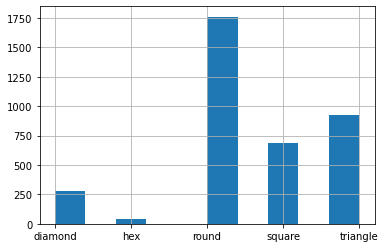

,image_path,sign_shape,isVal
0,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
1,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
2,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
3,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0
4,./trafficsigns_dataset\diamond\rightofway\0003...,diamond,0


In [100]:
data.sign_shape.hist()
#plt.rcParams["figure.figsize"] = (15,15)
plt.show()
data.head()
data[data['isVal']==0].head()

Now lets plot some images randomly and observe

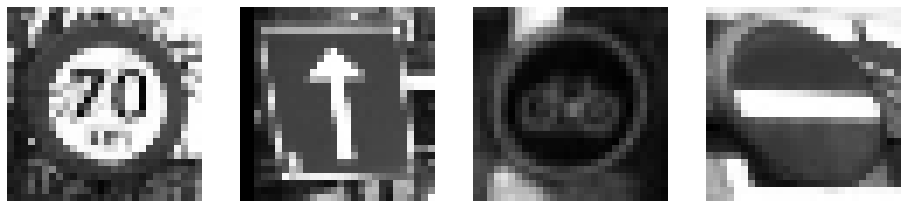

In [101]:
r_inx = np.random.choice(3000, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

The labels are in strings, they need to be converted to numeric values

In [102]:
d = {'hex':0, 'diamond':1, 'round':2, 'square':3, 'triangle':4}
data['labels_num'] = data['sign_shape'].map(d, na_action='ignore')

Lets now create 2 data frames `train_df` and `validation_df` for training and validating the data and afterwards pritning each ones size

In [103]:
train_df = data[data['isVal']==0].reset_index()
validation_df = data[data['isVal']==1].reset_index()
print('Train size: {}, Val size: {}'.format(train_df.shape[0], validation_df.shape[0] ) )
N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]

train_df.to_csv('SignTrainData.csv')
validation_df.to_csv('SignValData.csv')

Train size: 3699, Val size: 0


In [104]:
data = pd.read_csv('./SignTrainData.csv')

train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=42)

print("Train data : {}, Val Data: {}".format(train_df.shape[0], validation_df.shape[0]))

Train data : 2959, Val Data: 740


## Building the base model

To build and train our nueral network we will use Keras, a high level API which is a part of tensorflow. To build the neural network we will build the layers for the model and then compile it and finally train the model

### Configuring the layers

We will first define the dimensions for the nueral network

In [105]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

We will be using the simplest model `Sequential` API for building the model

In [106]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

To transform the format of the images from 2D array to a 1D array `tf.keras.layers.Flatten` will be used. 

Using `model.summary()` we can print the model that was created

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 256)               602368    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 603,653
Trainable params: 603,653
Non-trainable params: 0
_________________________________________________________________


To further visualize we use `tf.keras.utils.plot_model`

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Compiling the model

Before training the model we will be adding the **Loss function** (to measure how accurate the model is during traning), **Optimizer** and **Metrics**.


We will be using `CategoricalCrossentropy` since there are more than 2 categories in the output variable.

In [14]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### Loading the data

Since we are working with a large data set and we will need to load the data in batches to memory efficiently, this can be achieved using image data genarators within Keras.

We will be taking the datagrames that we designed earlier and define a loading function. 

Using the the `flow_from_dataframe` function within the Keras data loader we can load a set of images directly form a pandas dataframe. Using this we are aable to load the train and validation data. 

To speed up the training process we use the recommended range for normalizing the pixel of 0-1. 

In [15]:


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


### Training the model

To train the model we use the `model.fit_generator` function within Keras.

In [16]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

<ipython-input-16-3d796bb80333>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)


Using the `history` variable which holds the information we can plot the traing curves.

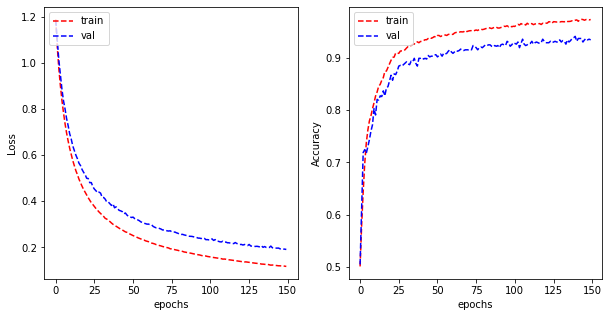

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Applying regularization

Since the model is over fitting we will do some incremental updates to improve the model and in order to do this we will add some ridge penalty which requires us to create a new model. 


In [18]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [19]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [20]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

<ipython-input-20-2cec612c9b52>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)


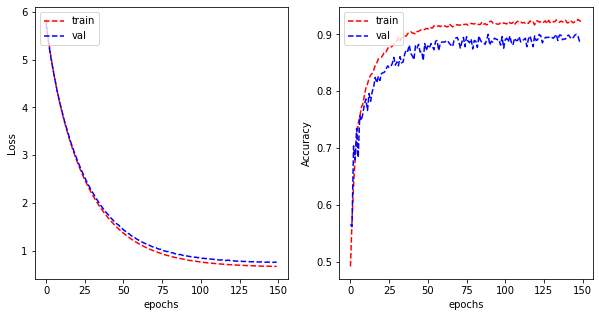

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

To further reduce over fitting we will be using Dropout. 

In [22]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [23]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [24]:
history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

<ipython-input-24-1cc7a45fcd89>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)


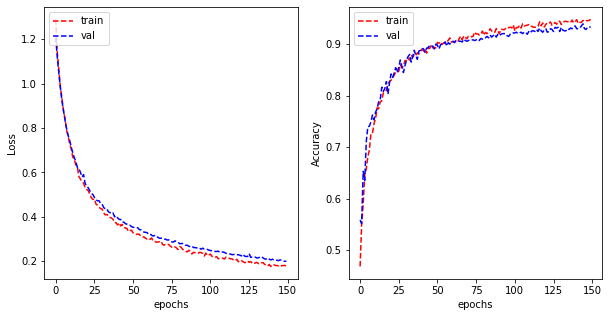

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [26]:
#model.save("base_model")

In [27]:
#base_model = tf.keras.models.load_model('base_model')

### Predicting sign shapes from test set

We will now create a data generator to form the test data and finally plot the data

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

test_generator = train_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 740 validated image filenames belonging to 5 classes.


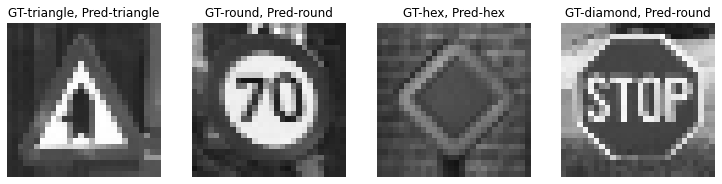

In [29]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_reg.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [219]:
import zipfile
with zipfile.ZipFile('./testing.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [220]:
test_data = []

In [221]:
image_list = []
for filepath in glob.glob('./testing\\*\\*\\*.png', recursive=True):
    filename = filepath.split("\\")[-1]
    shape = filepath.split("\\")[-2] #shape of signs
    sign = filepath.split("\\")[-3] #type of sign 
    polenumber = filename.split("_")[-1]
    test = shape in test_data
    image_list.append((filepath, shape))

#creating dataframe    
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

data['label'].unique()
data.head()

,image_path,label
0,./testing\DATA\15\hex1.png,15
1,./testing\DATA\15\hex2.png,15
2,./testing\DATA\15\hex3.png,15
3,./testing\DATA\15\hex4.png,15
4,./testing\DATA\15\hex5.png,15


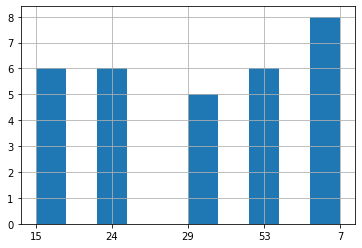

In [222]:
data.label.hist()
#plt.rcParams["figure.figsize"] = (15,15)
plt.show()

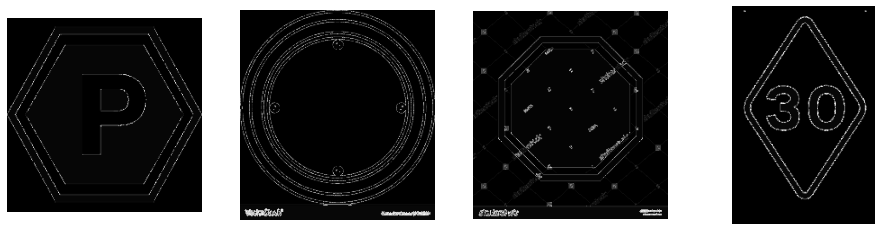

In [223]:
r_inx = np.random.choice(30, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [224]:
test_df = data.reset_index()
print('Test size: {}'.format(test_df.shape[0]) )
N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]

test_df.to_csv('SignTestData.csv')

Test size: 31


In [228]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 31 validated image filenames belonging to 5 classes.


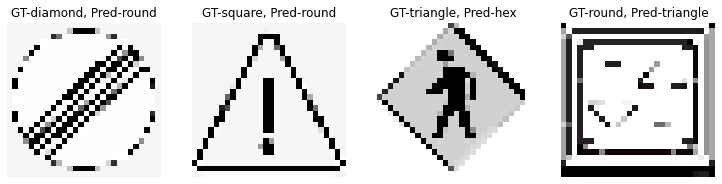

In [229]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_reg.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')